# 1 + 1 = 1 or Record Deduplication with Python
Flávio Juvenal  
[@flaviojuvenal](https://twitter.com/flaviojuvenal)  

<p>
    Partner at <a href="http://www.vinta.com.br?dedupe-slides=1"><img class="vinta_logo" style="display: inline-block; margin-left: 0;" src="vinta.png" width=300></a>
</p>

<p style="font-size: 2em; text-weight: bold">
    Slides available at: <a href="http://bit.ly/pybay-dupe">bit.ly/pybay-dupe</a> (open as Desktop)
</p>
<p>
    Jupyter Notebook source at: <a href="https://github.com/vintasoftware/deduplication-slides/">github.com/vintasoftware/deduplication-slides/</a>
</p>

## Introduction

Real world data is inputted by people and often it's:
* Not reviewed
* Not linked with related data
* Not properly normalized by the input system
* Or simply it's incorrectly inputted because people make mistakes: typos, mishearing, miscalculation, misinterpretation, etc.

This causes the following problems on data:
* lack of unique identifiers (making difficult detect duplicates in a dataset or to link with other datasets)
* duplications (e.g. multiple records refer to a single person)
* inconsistencies (e.g. a person appears with multiple addresses)
* bad formatting (e.g. birth dates appear with multiple formats like DD/MM/YY and YYYY-MM-DD)

All of that affects the ability to properly **extract knowledge** from one or more datasets.

The solution is to perform **[Record Linkage](https://en.wikipedia.org/wiki/Record_linkage)**. It works by joining records in a **fuzzy way** using data like names, addresses, phone numbers, dates, etc.

The term Record Linkage is most used when the linkage is applied to multiple datasets, like joining a Restaurant Food Inspection dataset with an Employee Wage dataset. In fact, [someone did just that](https://www.enigma.com/blog/on-wages-and-hygiene-surfacing-bad-management-in-public-data).

Record Linkage is also known as Data Matching, Entity Resolution, and [other names](https://en.wikipedia.org/wiki/Record_linkage#Naming_conventions).

What we'll discuss here is a specific application of Record Linkage, called **Deduplication**, which is applying Record Linkage on a single dataset against itself to **find which records are duplicates**. Here's a very simple example:

In [1]:
import warnings; warnings.simplefilter('ignore')
import logging; logging.disable(level=logging.INFO)

In [2]:
import pandas as pd

data = [
    ("Chin's","3200 Las Vegas Boulevard","New York"),
    ("Chin Bistro","3200 Las Vegas Blvd.","New York"),
    ("Bistro","3400 Las Vegas Blvd.","New York City"),
    ("Bistro","3400 Las Vegas B.","NYC"),
]

df = pd.DataFrame(data, columns=['restaurant', 'address', 'city'])

In [3]:
df

,restaurant,address,city
0,Chin's,3200 Las Vegas Boulevard,New York
1,Chin Bistro,3200 Las Vegas Blvd.,New York
2,Bistro,3400 Las Vegas Blvd.,New York City
3,Bistro,3400 Las Vegas B.,NYC


A good deduplication on the data above would find that:
  - `(0, 1)` are duplicates
  - `(2, 3)` are duplicates 
  - but `(0, 1)` and `(2, 3)` are different, despite being similar

## Process

The process for deduplicating a dataset usually is:
  0. Preprocessing
    * input: dataset 
    * output: cleaned dataset
  1. Indexing
    * output: pairs to compare
  2. Comparison
    * output: comparison vectors
  3. Classification
    * output: matching/nonmatching pairs
  4. Clustering 
    * output: unique record clusters
    
Let's explore each of those steps!

## 0/4 - Preprocessing
Without unique identifiers, we need to match records by fuzzy data like:
- Names
- Addresses
- Phone Numbers
- Dates

So it's important to **clean** them for matching.

### Cleaning names (companies or people)

Let's use string functions and regexes to **normalize** names and remove undesired variations:

In [4]:
import numpy as np
import re
import pprint


company_names = company_names_dirty = [
    'APPLE COMPUTER INC',
    'APPLE COMPUTER, INC.',
    'APPLE INC',
    'Apple Computer',
    'Apple Computer Co.',
    'Apple Computer Company',
    'Apple Computer Inc',
    'Apple Computer Incorporated',
    'Apple Computer, Inc.',
    'Apple Inc',
    'Apple Inc.',
    'Apple, Inc.'
]

In [5]:
print("Lower case:")
company_names = [c.lower() for c in company_names]
pprint.pprint(company_names)

Lower case:
['apple computer inc',
 'apple computer, inc.',
 'apple inc',
 'apple computer',
 'apple computer co.',
 'apple computer company',
 'apple computer inc',
 'apple computer incorporated',
 'apple computer, inc.',
 'apple inc',
 'apple inc.',
 'apple, inc.']


In [6]:
print("Remove irrelevant separators:")
irrelevant_regex = re.compile(r'[^a-z0-9\s]')
company_names = [irrelevant_regex.sub(' ', c) for c in company_names]
pprint.pprint(company_names)

Remove irrelevant separators:
['apple computer inc',
 'apple computer  inc ',
 'apple inc',
 'apple computer',
 'apple computer co ',
 'apple computer company',
 'apple computer inc',
 'apple computer incorporated',
 'apple computer  inc ',
 'apple inc',
 'apple inc ',
 'apple  inc ']


In [7]:
print("Remove multi-spaces:")
multispace_regex = re.compile(r'\s\s+')
company_names = [multispace_regex.sub(' ', c).strip() for c in company_names]
pprint.pprint(company_names)

Remove multi-spaces:
['apple computer inc',
 'apple computer inc',
 'apple inc',
 'apple computer',
 'apple computer co',
 'apple computer company',
 'apple computer inc',
 'apple computer incorporated',
 'apple computer inc',
 'apple inc',
 'apple inc',
 'apple inc']


In [8]:
print("Remove stopwords:")
business_stopwords = {  # suppose we got this from somewhere
    'computer',
    'co',
    'company',
    'corp',
    'corporation',
    'inc',
    'incorporated',
    'llc',
    #...
}

company_names = [
    ' '.join([c_part for c_part in c.split() if c_part not in business_stopwords])
    for c in company_names
]
pprint.pprint(company_names)

Remove stopwords:
['apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple']


We can also use the natural language processing library [**probablepeople**](https://github.com/datamade/probablepeople) to **parse company names** and extract just the parts we want (or break into parts and match by part on the comparison step later):

In [9]:
import probablepeople as pp

pp.parse("Apple Computer Incorporated")

[('Apple', 'CorporationName'),
 ('Computer', 'CorporationName'),
 ('Incorporated', 'CorporationLegalType')]

In [10]:
company_names_alternative_1 = [
    [
        parsed_value
        for parsed_value, parsed_type
        in pp.parse(c)
        if parsed_type == 'CorporationName'
    ]
    for c in company_names_dirty
]
pprint.pprint(company_names_alternative_1)

[['APPLE', 'COMPUTER'],
 ['APPLE', 'COMPUTER,'],
 ['APPLE'],
 ['Apple', 'Computer'],
 ['Apple', 'Computer'],
 ['Apple', 'Computer'],
 ['Apple', 'Computer'],
 ['Apple', 'Computer'],
 ['Apple', 'Computer,'],
 ['Apple'],
 ['Apple'],
 ['Apple,']]


probablepeople, as the name suggests, can parse **people** names too:

In [11]:
pp.parse('Mr. Guido van Rossum')

[('Mr.', 'PrefixMarital'),
 ('Guido', 'GivenName'),
 ('van', 'Surname'),
 ('Rossum', 'Surname')]

If it's useful to **ignore accents**, try [**unidecode**](https://github.com/avian2/unidecode):

In [12]:
import unidecode

print("ASCII transliteration:")
brazilian_name = "Flávio"
print(brazilian_name, "->")
print(unidecode.unidecode(brazilian_name))

ASCII transliteration:
Flávio ->
Flavio


### Cleaning addresses

Geocoding street addresses, i.e., converting them to **latitude/longitude** is very useful for matching, because geocoders usually clean irrelevant address variations. Also, having lat/lng enables the calculation of geometric distances between addresses.

In [13]:
import requests
import geocoder

full_addresses = [
    "2066 Crist Drive, 94024, Los Altos, CALIFORNIA, US",
    "2066 Crist Dr, 94024, LOS ALTOS, CALIFORNIA, US",
    "20863 Stevens Creek Blvd., Suite 300, 95015, CUPERTINO, CALIFORNIA, US",
    "20863 STEVENS CREEK BLVD STE 330, 95014, Lupertino, CALIFORNIA, US",
    "10260 Bandley Drive, 95014, Cupertino, CALIFORNIA, US",
    "10260 Bandley Dr., 95014, Cupertino, CALIFORNIA, US",
    "20525 MARIANI AVENUE, 95014, CUPERTINO, CALIFORNIA, US",
    "20525 Mariani Ave, 95014, CUPERTINO, CALIFORNIA, US",
    "1 Infinite Loop, 95014, Cupertino, CALIFORNIA, US",
    "One Infinite Loop,, 95014, Cupertino, CALIFORNIA, US",
    "One Apple Park Way, 95014, Cupertino, CALIFORNIA, US",
    "1 Apple Park Way, 95014, Cupertino, CALIFORNIA, US",
]

full_addresses_latlng = []
for a in full_addresses:
    a_geocoded = geocoder.google(a)
    full_addresses_latlng.append(a_geocoded.latlng)

address_latlng = list(zip(full_addresses, full_addresses_latlng))

In [14]:
pprint.pprint((address_latlng[2], address_latlng[3]))
print()

(('20863 Stevens Creek Blvd., Suite 300, 95015, CUPERTINO, CALIFORNIA, US',
  [37.3241563, -122.0387297]),
 ('20863 STEVENS CREEK BLVD STE 330, 95014, Lupertino, CALIFORNIA, US', None))



Google geocoder is able to:
- Ignore lower/upper case difference
- Ignore the difference between Suite 300 vs 330 (building entrance may be the same)
- Consider 'Lupertino' as 'Cupertino'
- Expand abbreviations, like 'STE' vs 'Suite'

Note geocoding from web APIs is slow and has quota limits! Alternatively, you can build **your own geocoder** with:
- https://github.com/openstreetmap/Nominatim
- https://github.com/pelias/pelias
- https://github.com/komoot/photon
- https://postgis.net/docs/Extras.html
- https://github.com/openvenues/lieu

From [DataMade](https://datamade.us/), the creators of probablepeople, there's a [**usaddress**](https://github.com/datamade/usaddress) **parser**:

In [15]:
import usaddress

print(full_addresses[0])
pprint.pprint(usaddress.parse(full_addresses[0]))
print()
print(full_addresses[1])
pprint.pprint(usaddress.parse(full_addresses[1]))

2066 Crist Drive, 94024, Los Altos, CALIFORNIA, US
[('2066', 'AddressNumber'),
 ('Crist', 'StreetName'),
 ('Drive,', 'StreetNamePostType'),
 ('94024,', 'SubaddressIdentifier'),
 ('Los', 'PlaceName'),
 ('Altos,', 'PlaceName'),
 ('CALIFORNIA,', 'PlaceName'),
 ('US', 'StateName')]

2066 Crist Dr, 94024, LOS ALTOS, CALIFORNIA, US
[('2066', 'AddressNumber'),
 ('Crist', 'StreetName'),
 ('Dr,', 'StreetNamePostType'),
 ('94024,', 'ZipCode'),
 ('LOS', 'PlaceName'),
 ('ALTOS,', 'PlaceName'),
 ('CALIFORNIA,', 'PlaceName'),
 ('US', 'StateName')]


### Cleaning phone numbers

[**phonenumbers**](https://github.com/daviddrysdale/python-phonenumbers) library can **normalize** phone numbers from many countries:

In [16]:
import phonenumbers

print("Phone number normalization:")
phone = "(541) 555-3010"
print(phone, '->')
print(
    phonenumbers.format_number(
        phonenumbers.parse(phone, 'US'),
        phonenumbers.PhoneNumberFormat.E164)
)

Phone number normalization:
(541) 555-3010 ->
+15415553010


### Cleaning dates

[**dateparser**](https://github.com/scrapinghub/dateparser) library can **guess** date formats and parse them as datetime objects. It can even guess DD/MM or MM/DD by the language:

In [17]:
import dateparser

print(dateparser.parse("at 10/1/2018 10am"))
print(dateparser.parse("às 10/1/2018 10:00"))
pprint.pprint(dateparser.DateDataParser().get_date_data("às 10/1/2018 10:00"))

2018-10-01 10:00:00
2018-01-10 10:00:00
{'date_obj': datetime.datetime(2018, 1, 10, 10, 0),
 'locale': 'pt',
 'period': 'day'}


Check also [**dateutil parser**](https://dateutil.readthedocs.io/en/stable/parser.html#dateutil.parser.parse) with `fuzzy=True`.

### Cleaning a real dataset

Now we know the tools, let's **grab a dataset to preprocess and go on the other deduplication steps**. Our dataset is based* on the [Restaurant](https://www.cs.utexas.edu/users/ml/riddle/data.html) dataset, a well-known dataset used by researchers. It contains 881 restaurant records and contains 150 duplicates.

\* We've introduced some changes that you can check by doing a `diff restaurant.original.csv restaurant.csv`

In [18]:
df_with_truth = pd.read_csv('restaurant.csv', skip_blank_lines=True)
df_with_truth.head(9)

,name,addr,city,phone,type,cluster
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles,310/246-1501,american,0
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles,310-246-1501,steakhouses,0
2,arnie morton,435 s. la cienega boulevard,los angeles,310-246-1501,steakhouses,0
3,art's delicatessen,12224 ventura blvd.,studio city,818/762-1221,american,1
4,art's deli,12224 ventura blvd.,studio city,818-762-1221,delis,1
5,art's deli,12224 ventura blvd.,los angeles,818-762-1221,delis,1
6,hotel bel-air,701 stone canyon rd.,bel air,310/472-1211,californian,2
7,bel-air hotel,701 stone canyon rd.,bel air,310-472-1211,californian,2
8,bel-air,701 stone canyon road,bel air,(310) 472-1211,american,2


The dataset comes with the true matches indicated by the 'cluster' column. We'll remove it. We'll also remove the 'phone' to makes things more difficult:

In [19]:
df = df_with_truth.drop(columns=['cluster', 'phone'])
df.head(9)

,name,addr,city,type
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles,american
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles,steakhouses
2,arnie morton,435 s. la cienega boulevard,los angeles,steakhouses
3,art's delicatessen,12224 ventura blvd.,studio city,american
4,art's deli,12224 ventura blvd.,studio city,delis
5,art's deli,12224 ventura blvd.,los angeles,delis
6,hotel bel-air,701 stone canyon rd.,bel air,californian
7,bel-air hotel,701 stone canyon rd.,bel air,californian
8,bel-air,701 stone canyon road,bel air,american


Now we'll clean the column values! Cleaning **name**:

In [20]:
def assign_no_symbols_name(df):
    return df.assign(
        name=df['name']
             .str.replace(irrelevant_regex, ' ')
             .str.replace(multispace_regex, ' '))

df = assign_no_symbols_name(df)
df.head(9)

,name,addr,city,type
0,arnie morton s of chicago,435 s. la cienega blv.,los angeles,american
1,arnie morton s of chicago,435 s. la cienega blvd.,los angeles,steakhouses
2,arnie morton,435 s. la cienega boulevard,los angeles,steakhouses
3,art s delicatessen,12224 ventura blvd.,studio city,american
4,art s deli,12224 ventura blvd.,studio city,delis
5,art s deli,12224 ventura blvd.,los angeles,delis
6,hotel bel air,701 stone canyon rd.,bel air,californian
7,bel air hotel,701 stone canyon rd.,bel air,californian
8,bel air,701 stone canyon road,bel air,american


Geocoding **addr**:

In [21]:
all_addresses = df['addr'].str.cat(df['city'], sep=', ').values
unique_addresses = np.unique(all_addresses)
print(len(all_addresses), len(unique_addresses))

881 819


In [22]:
import os.path
import json

geocoding_filename = 'address_to_geocoding.json'

def geocode_addresses(address_to_geocoding):
    remaining_addresses = (
        set(unique_addresses) -
        set(k for k, v in address_to_geocoding.items() if v is not None))
    
    with requests.Session() as session:
        for i, address in enumerate(remaining_addresses):
            print(f"Geocoding {i + 1}/{len(remaining_addresses)}")
            geocode_result = geocoder.google(address, session=session)
            address_to_geocoding[address] = geocode_result.json

        with open(geocoding_filename, 'w') as f:
            json.dump(address_to_geocoding, f, indent=4)

if not os.path.exists(geocoding_filename):
    address_to_geocoding = {}
    geocode_addresses(address_to_geocoding)
else:
    with open(geocoding_filename) as f:
        address_to_geocoding = json.load(f)
    geocode_addresses(address_to_geocoding)
 
address_to_postal = {
    k: v['postal']
    for k, v in address_to_geocoding.items()
    if v is not None and 'postal' in v
}
address_to_latlng = {
    k: (v['lat'], v['lng'])
    for k, v in address_to_geocoding.items()
    if v is not None
}
print(f"Failed to get postal from {len(address_to_geocoding) - len(address_to_postal)}")
print(f"Failed to get latlng from {len(address_to_geocoding) - len(address_to_latlng)}")

Failed to get postal from 8
Failed to get latlng from 0


In [23]:
def assign_postal_lat_lng(df):
    addresses = df['addr'].str.cat(df['city'], sep=', ')
    addresses_to_postal = [address_to_postal.get(a) for a in addresses]
    addresses_to_lat = [address_to_latlng[a][0] if a in address_to_latlng else None for a in addresses]
    addresses_to_lng = [address_to_latlng[a][1] if a in address_to_latlng else None for a in addresses]

    return df.assign(postal=addresses_to_postal, lat=addresses_to_lat, lng=addresses_to_lng)

df = assign_postal_lat_lng(df)
df.head(6)

,name,addr,city,type,postal,lat,lng
0,arnie morton s of chicago,435 s. la cienega blv.,los angeles,american,90048,34.070609,-118.376722
1,arnie morton s of chicago,435 s. la cienega blvd.,los angeles,steakhouses,90048,34.070609,-118.376722
2,arnie morton,435 s. la cienega boulevard,los angeles,steakhouses,90048,34.070609,-118.376722
3,art s delicatessen,12224 ventura blvd.,studio city,american,91604,34.142966,-118.399469
4,art s deli,12224 ventura blvd.,studio city,delis,91604,34.142966,-118.399469
5,art s deli,12224 ventura blvd.,los angeles,delis,91604,34.142966,-118.399469


Now, with a clean dataset, we can move to the next step.

## 1/4 - Indexing

To explain the following deduplication steps, we'll use the Python libary **recordlinkage**, aka **[Python Record Linkage Toolkit](http://recordlinkage.readthedocs.io/en/stable/)**. We choose it because it doesn't abstract too much the details of the process, even though it has a simple API.

We have the cleaned records, we now need the pairs we want to compare to find matches.
To **produce the pairs**, we could do a "full" index, i.e., all records against all records:

In [24]:
import recordlinkage as rl
from recordlinkage.index import Full

full_indexer = Full()
pairs = full_indexer.index(df)

print(f"Full index: {len(df)} records, {len(pairs)} pairs")

Full index: 881 records, 387640 pairs


The formula for the total number of pairs is:  
`len(df) * (len(df) - 1) / 2 == 387640`

<div><img style="display: block; margin: 0 auto;" src="full-indexing.png?" width=800></div>

The number of pairs grows too fast as the number of records grows: it **grows quadratically**.
That's why we need **indexing**. We need to produce only pairs that are good candidates of being duplicates to avoid wasting too much time.

Indexing is also called **blocking** because the trivial way to index is to produce pairs that have **some column value in common**. By doing this, we produce blocks of record pairs and compare only those in the same block:

<div><img style="display: block; margin: 0 auto;" src="standard-blocking.png?" width=800></div>

Below we produce pairs that have **equal values for postal** code:

In [25]:
from recordlinkage.index import Block

postal_indexer = Block('postal')
postal_index_pairs = postal_indexer.index(df)

print(f"Postal index: {len(postal_index_pairs)} pairs")

Postal index: 6536 pairs


We could also produce pairs by sorting the unique values of some column and, for each value, getting the records with **neighboring values**. The idea is to produce pairs with close values on some column, like `johnny` and `john` or  `2018-01-02` and `2018-01-05`. It looks like this:

<div><img style="display: block; margin: 0 auto;" src="sorted-neighbourhood.png?" width=800></div>

Below we produce pairs that have **neighboring values for name**:

In [26]:
from recordlinkage.index import SortedNeighbourhood

name_indexer = SortedNeighbourhood('name', window=7)
name_index_pairs = name_indexer.index(df)

print(f"Name index: {len(name_index_pairs)} pairs")

Name index: 3074 pairs


Note that simply sorting values wouldn't be able to get `kamila` and `camila` as neighbors, as sorting is sensitive to the leading characters of strings. There are other ways to index that could handle that, check Christen, chapter 4 [2].

To produce more pairs without introducing redundant pairs, we should **union** different indexes:

In [27]:
pairs = postal_index_pairs.union(name_index_pairs)

print(f"Postal or name index: {len(pairs)} pairs")

Postal or name index: 9414 pairs


In [28]:
# We'll swap the levels of pairs MultiIndex returned by recordlinkage
# to make it simpler to interpret. Here we get the upper triangle of the pairs matrix.
pairs = pairs.swaplevel().sortlevel()[0]

We now have **which pairs** we want to run comparisons on!

## 2/4 - Comparison

Now we want to run comparisons on the indexed pairs to produce **a comparison vector for each pair**. A comparison vector represents the similarity between 2 records by holding similarity values between 0 to 1 for each column.

In [29]:
pd.DataFrame([[1.0, 0.75, 0.0, 0.25, 0.0]],
             columns=['name', 'addr', 'type', 'latlng', 'addr_variations'],
             index=pd.MultiIndex.from_arrays([[100], [200]]))

,,name,addr,type,latlng,addr_variations
100,200,1.0,0.75,0.0,0.25,0.0


For example, the comparison vector above means the pair of records `(100, 200)` has:
- Equal `name`s
- Similar `addr`s
- Completely different `type`s
- Some distance on `latlng`s
- No agreement on `addr_variations`

To compute the comparison vectors for all indexed pairs, we define a **similarity function** for each column:

In [30]:
comp = rl.Compare()
comp.string('name', 'name', method='jarowinkler', label='name')
comp.string('addr', 'addr', method='jarowinkler', label='addr')
comp.string('city', 'city', method='jarowinkler', label='city')
comp.string('type', 'type', method='jarowinkler', label='type')
comp.geo('lat', 'lng', 'lat', 'lng', method='exp', scale=0.5, label='latlng');

There are many similarity functions we could use for **strings**. For example:
- `jarowinkler` gives priority to the begining of the string
- `levenshtein` cares more about the order
- `lcs` cares less about the order

For more details on the different similarity functions you can use, check Christen, chapter 5 [2]. Also, check the similarity functions [implemented on recordlikage library](http://recordlinkage.readthedocs.io/en/stable/ref-compare.html).

Now we'll compute the **comparison vectors**:

In [31]:
comparison_vectors = comp.compute(pairs, df)
comparison_vectors.head(5)

name      addr     city      type   latlng
0 1  1.000000  0.985507  1.00000  0.310606  1.00000
  2  0.896000  0.910774  1.00000  0.310606  1.00000
  3  0.562492  0.593620  0.40404  1.000000  0.00001
  4  0.581667  0.593620  0.40404  0.550000  0.00001
  5  0.581667  0.593620  1.00000  0.550000  0.00001

Now, with our comparison vectors, we'll explore **different ways** to classify them as matches and nonmatches.

## 3/4 - Classification

Before, let's remember what's on records `0` to `5`:

In [32]:
df.head(6)

,name,addr,city,type,postal,lat,lng
0,arnie morton s of chicago,435 s. la cienega blv.,los angeles,american,90048,34.070609,-118.376722
1,arnie morton s of chicago,435 s. la cienega blvd.,los angeles,steakhouses,90048,34.070609,-118.376722
2,arnie morton,435 s. la cienega boulevard,los angeles,steakhouses,90048,34.070609,-118.376722
3,art s delicatessen,12224 ventura blvd.,studio city,american,91604,34.142966,-118.399469
4,art s deli,12224 ventura blvd.,studio city,delis,91604,34.142966,-118.399469
5,art s deli,12224 ventura blvd.,los angeles,delis,91604,34.142966,-118.399469


### Threshold-Based Classification

A simple way to classify comparison vectors as matches or nonmatches is to compute a **weighted average** over the vectors to get a **score**:

In [33]:
scores = np.average(
    comparison_vectors.values,
    axis=1,
    weights=[40, 20, 15, 5, 20])
scored_comparison_vectors = comparison_vectors.assign(score=scores)
scored_comparison_vectors.head(5)

name      addr     city      type   latlng     score
0 1  1.000000  0.985507  1.00000  0.310606  1.00000  0.962632
  2  0.896000  0.910774  1.00000  0.310606  1.00000  0.906085
  3  0.562492  0.593620  0.40404  1.000000  0.00001  0.454329
  4  0.581667  0.593620  0.40404  0.550000  0.00001  0.439499
  5  0.581667  0.593620  1.00000  0.550000  0.00001  0.528893

By looking at the data, we know record `0` truly matches `1` and `2`, so we'll **classify as a match** any pair with score `>= 0.85`. That's our **threshold**:

In [34]:
matches = comparison_vectors[
    scored_comparison_vectors['score'] >= 0.9]
matches.head(5)

name      addr     city      type  latlng
0 1  1.000000  0.985507  1.00000  0.310606     1.0
  2  0.896000  0.910774  1.00000  0.310606     1.0
1 2  0.896000  0.923779  1.00000  1.000000     1.0
3 4  0.911111  1.000000  1.00000  0.550000     1.0
4 5  1.000000  1.000000  0.40404  1.000000     1.0

Let's check another match we've found with this threshold: what are the matches of record `3`?

In [35]:
display(df.loc[[3]])
print("matched:")
display(df.loc[matches.loc[(3,)].index])

,name,addr,city,type,postal,lat,lng
3,art s delicatessen,12224 ventura blvd.,studio city,american,91604,34.142966,-118.399469


matched:


,name,addr,city,type,postal,lat,lng
4,art s deli,12224 ventura blvd.,studio city,delis,91604,34.142966,-118.399469


Seems OK! Since we have the true match status on `cluster` column, we can **evaluate** how well our threshold classification did:

In [36]:
golden_pairs = Block('cluster').index(df_with_truth)
golden_pairs = golden_pairs.swaplevel().sortlevel()[0]
print("Golden pairs:", len(golden_pairs))

Golden pairs: 150


In [37]:
found_pairs_set = set(matches.index)

golden_pairs_set = set(golden_pairs)

true_positives = golden_pairs_set & found_pairs_set
false_positives = found_pairs_set - golden_pairs_set
false_negatives = golden_pairs_set - found_pairs_set

print('true_positives total:', len(true_positives))
print('false_positives total:', len(false_positives))
print('false_negatives total:', len(false_negatives))

true_positives total: 118
false_positives total: 3
false_negatives total: 32


We've got a small number of **false positives**. Some are really tricky cases:

In [38]:
print(f"False positives:")
for false_positive_pair in false_positives:
    display(df.loc[list(false_positive_pair)][['name', 'addr', 'city', 'type', 'lat', 'lng']])

False positives:


,name,addr,city,type,lat,lng
762,palm,837 second ave.,new york city,steakhouses,40.751701,-73.971180
763,palm too,840 second ave.,new york city,steakhouses,40.751467,-73.970686


,name,addr,city,type,lat,lng
196,ritz carlton cafe buckhead,3434 peachtree rd. ne,atlanta,american (new),33.850807,-84.364227
198,ritz carlton dining room buckhead,3434 peachtree rd. ne,atlanta,american (new),33.850807,-84.364227


,name,addr,city,type,lat,lng
200,ritz carlton restaurant,181 peachtree st.,atlanta,french (classic),33.758579,-84.387066
839,ritz carlton cafe atlanta,181 peachtree st.,atlanta,american (new),33.758579,-84.387066


On the other hand, we got a lot of **false negatives**. We've **missed** a lot of matches!

In [39]:
print(f"False negatives (sample 10 of {len(false_negatives)}):")
for false_negative_pair in list(false_negatives)[:10]:
    display(df.loc[list(false_negative_pair)][['name', 'addr', 'city', 'type', 'lat', 'lng']])

False negatives (sample 10 of 32):


,name,addr,city,type,lat,lng
182,heera of india,595 piedmont ave. rio shopping mall,atlanta,asian,33.795817,-84.370602
183,heera of india,595 piedmont ave.,atlanta,indian,33.770495,-84.381425


,name,addr,city,type,lat,lng
164,abruzzi,2355 peachtree rd. peachtree battle shopping ...,atlanta,italian,33.820137,-84.387280
165,abruzzi,2355 peachtree rd. ne,atlanta,italian,33.824647,-84.387453


,name,addr,city,type,lat,lng
28,restaurant katsu,1972 n. hillhurst ave.,los angeles,asian,34.107405,-118.28719
29,katsu,1972 hillhurst ave.,los feliz,japanese,34.107405,-118.28719


,name,addr,city,type,lat,lng
36,locanda veneta,8638 w 3rd,st los angeles,italian,34.073417,-118.381096
37,locanda,w. third st.,st los angeles,italian,34.068958,-118.320928


,name,addr,city,type,lat,lng
40,the palm,9001 santa monica blvd.,los angeles,american,34.083064,-118.387282
41,palm the los angeles,9001 santa monica blvd.,w. hollywood,steakhouses,34.083064,-118.387282


,name,addr,city,type,lat,lng
168,bone s,3130 piedmont road,atlanta,american,33.842103,-84.371103
169,bone s restaurant,3130 piedmont rd. ne,atlanta,steakhouses,33.842103,-84.371103


,name,addr,city,type,lat,lng
136,shun lee west,43 w. 65th st.,new york,asian,40.772900,-73.981348
137,shun lee palace,155 e. 55th st.,new york city,chinese,40.759428,-73.969068


,name,addr,city,type,lat,lng
110,mesa grill,102 5th ave. between 15th and 16th sts.,new york,american,40.737045,-73.993119
111,mesa grill,102 fifth ave.,new york city,southwestern,40.737045,-73.993119


,name,addr,city,type,lat,lng
34,locanda veneta,3rd st.,los angeles,italian,34.068958,-118.320928
35,locanda veneta,8638 w. third st.,los angeles,italian,34.073417,-118.381096


,name,addr,city,type,lat,lng
30,l orangerie,903 n. la cienega blvd.,los angeles,french,34.087098,-118.376626
31,l orangerie,903 n. la cienega blvd.,w. hollywood,french (classic),34.100833,-118.325613


We've set the weights and the threshold **by guessing**, could we do any better?

### Supervised Classification

Instead of trying to guess weights and thresholds, we can train a **classifier** to learn how to classify matches and nonmatches based on some training data we provide:

In [40]:
df_training = pd.read_csv('restaurant-training.csv', skip_blank_lines=True)
df_training = df_training.drop(columns=['phone'])
df_training

,name,addr,city,type,cluster
0,locanda veneta,3rd st.,los angeles,italian,13
1,locanda veneta,8638 w. third st.,los angeles,italian,13
2,locanda veneta,8638 w 3rd st,los angeles,italian,13
3,cafe lalo,201 w. 83rd st.,new york,coffee bar,26
4,cafe lalo,201 w. 83rd st.,new york city,coffeehouses,26
5,les celebrites,160 central park s,new york,french,42
6,les celebrites,155 w. 58th st.,new york city,french (classic),42
7,second avenue deli,156 2nd ave. at 10th st.,new york,delicatessen,58
8,second avenue deli,156 second ave.,new york city,delis,58
9,smith & wollensky,201 e. 49th st.,new york,american,62


We need to **preprocess** our training data too:

In [41]:
df_training = assign_no_symbols_name(df_training)
df_training = assign_postal_lat_lng(df_training)
df_training.head(5)

,name,addr,city,type,cluster,postal,lat,lng
0,locanda veneta,3rd st.,los angeles,italian,13,None,34.068958,-118.320928
1,locanda veneta,8638 w. third st.,los angeles,italian,13,90048,34.073417,-118.381096
2,locanda veneta,8638 w 3rd st,los angeles,italian,13,None,NaN,NaN
3,cafe lalo,201 w. 83rd st.,new york,coffee bar,26,10024,40.785981,-73.976727
4,cafe lalo,201 w. 83rd st.,new york city,coffeehouses,26,10024,40.785981,-73.976727


We'll feed a **Support Vector Machine** classifier with our training data. SVMs are resilient to noise, can handle correlated features (like 'addr' and 'latlng') and are robust to imbalanced training sets. That last attribute is relevant for deduplication, because we'll usually find more negative pairs than positive pairs to add to a training set. (Bilenko [3])

In [42]:
all_training_pairs = Full().index(df_training)
matches_training_pairs = Block('cluster').index(df_training)

training_vectors = comp.compute(all_training_pairs, df_training)

svm = rl.SVMClassifier()
svm.fit(training_vectors, matches_training_pairs);

In [43]:
svm_pairs = svm.predict(comparison_vectors)
svm_found_pairs_set = set(svm_pairs)

svm_true_positives = golden_pairs_set & svm_found_pairs_set
svm_false_positives = svm_found_pairs_set - golden_pairs_set
svm_false_negatives = golden_pairs_set - svm_found_pairs_set

print('true_positives total:', len(true_positives))
print('false_positives total:', len(false_positives))
print('false_negatives total:', len(false_negatives))
print()
print('svm_true_positives total:', len(svm_true_positives))
print('svm_false_positives total:', len(svm_false_positives))
print('svm_false_negatives total:', len(svm_false_negatives))

true_positives total: 118
false_positives total: 3
false_negatives total: 32

svm_true_positives total: 127
svm_false_positives total: 5
svm_false_negatives total: 23


**Better results**! The false positives we got on the SVM classifier and not on the threshold method is a really difficult case where most columns are very similar:

In [44]:
print("(SVM false positives) - (Threshold false positives):")
for svm_false_positive in (svm_false_positives - false_positives):
    display(df.loc[list(svm_false_positive)][['name', 'addr', 'city', 'type', 'lat', 'lng']])

(SVM false positives) - (Threshold false positives):


,name,addr,city,type,lat,lng
643,stars,150 redwood alley,san francisco,american,37.780894,-122.419481
644,stars cafe,500 van ness ave.,san francisco,american,37.780298,-122.420002


,name,addr,city,type,lat,lng
335,caffe dante,81 macdougal st. between houston and bleeker ...,new york,coffee bar,40.728878,-74.001662
337,caffe lure,169 sullivan st. between houston and bleecker...,new york,french,40.727928,-74.000985


But the SVM was tricked by some apparently simple cases, so **we can't be very confident** it really learned well to classify matches:

In [45]:
for svm_false_negative in list(svm_false_negatives)[:3]:
    display(df.loc[list(svm_false_negative)][['name', 'addr', 'city', 'type', 'lat', 'lng']])

,name,addr,city,type,lat,lng
182,heera of india,595 piedmont ave. rio shopping mall,atlanta,asian,33.795817,-84.370602
183,heera of india,595 piedmont ave.,atlanta,indian,33.770495,-84.381425


,name,addr,city,type,lat,lng
28,restaurant katsu,1972 n. hillhurst ave.,los angeles,asian,34.107405,-118.28719
29,katsu,1972 hillhurst ave.,los feliz,japanese,34.107405,-118.28719


,name,addr,city,type,lat,lng
36,locanda veneta,8638 w 3rd,st los angeles,italian,34.073417,-118.381096
37,locanda,w. third st.,st los angeles,italian,34.068958,-118.320928


There are [other classifiers](https://recordlinkage.readthedocs.io/en/stable/notebooks/classifiers.html) from recordlinkage library we could try, but the truth is:
- It's **very difficult to build a good training set** that takes in account all important cases of matches/nonmatches
- It's possible to tune classifier parameters to get better results, but it's very difficult to **decide the right parameters that will generalize well** for future predictions
- And we're not even sure **if the indexing rules we used are really sane**: we can be dropping true positives that are not being blocked together, or even introducing false negatives that are being blocked together but our classifier isn't being able classify them as nonmatching

The **alternative** to all that uncertainty is...

### Active Learning Classification

Active Learning methods identify **training examples** that "lead to maximal accuracy improvements" (Bilenko [3]), both to train **optimal classifier weights**, as well as to find **optimal indexing/blocking rules**! A Python library called [Dedupe](https://docs.dedupe.io/en/latest/index.html) implements that.

We'll see it in practice. First we define the fields/columns of our data:

In [46]:
import logging; logging.disable(level=logging.NOTSET)

In [47]:
import dedupe

fields = [
    {
        'field': 'name',
        'variable name': 'name',
        'type': 'ShortString',
        'has missing': True
    },
    {
        'field': 'addr',
        'variable name': 'addr',
        'type': 'ShortString',
    },
    {
        'field': 'city',
        'variable name': 'city',
        'type': 'ShortString',
        'has missing': True
    },
    {
        'field': 'postal',
        'variable name': 'postal',
        'type': 'ShortString',
        'has missing': True
    },
    {
        'field': 'latlng',
        'variable name': 'latlng',
        'type': 'LatLong',
        'has missing': True
    },
    {'type': 'Interaction', 'interaction variables': [
        'addr',
        'city',
        'postal',
        'latlng',
    ]},
]

Now we **initialize** the Dedupe instance with the fields. We can also use a pre-saved pickled Dedupe instance:

In [48]:
settings_filename = 'dedupe-simple-settings.pickle'
if os.path.exists(settings_filename):
    with open(settings_filename, 'rb') as sf:
        deduper = dedupe.StaticDedupe(sf, num_cores=4)
else:
    deduper = dedupe.Dedupe(fields, num_cores=4)

INFO:dedupe.api:((SimplePredicate: (firstIntegerPredicate, addr), SimplePredicate: (firstTokenPredicate, name)), SimplePredicate: (fingerprint, name))


We need to **adapt** the data a bit to the format Dedupe wants:

In [49]:
data_for_dedupe = df.assign(cluster=df_with_truth['cluster']).to_dict('index')
for record in data_for_dedupe.values():
    # Change nans to None
    for k, v in record.items():
        if isinstance(v, float) and np.isnan(v):
            record[k] = None
    
    # Move lat and lng to a single field latlng
    lat = record.pop('lat')
    lng = record.pop('lng')
    if lat is not None and lng is not None:
        record['latlng'] = (lat, lng)
    else:
        record['latlng'] = None

Here we're using a Dedupe instance that we trained before. Let's check how was the **training input/output**:

In [50]:
training_input_output = 'training-simple-input-output.txt'
if os.path.exists(training_input_output):
    with open(training_input_output) as t:
        txt = t.read()
        print('\n'.join(txt.split('\n')[:112]))
print('...')

distinct
name : cite
addr : 120 w. 51st st.
city : new york
postal : 10019
latlng : (40.7607952, -73.9812268)

name : ruth s chris
addr : 148 w. 51st st.
city : new york
postal : 10019
latlng : (40.7613323, -73.9821595)

0 0

distinct
name : rainbow room
addr : 30 rockefeller plaza
city : new york
postal : 10111
latlng : (40.7593755, -73.9799726)

name : zankou chicken
addr : 1415 e. colorado st.
city : glendale
postal : 91205
latlng : (34.1432176, -118.2333374)

0 1

INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(SimplePredicate: (commonThreeTokens, name), SimplePredicate: (commonTwoTokens, city))
match
name : tavern on the green
addr : in central park at 67th st.
city : new york
postal : 10023
latlng : (40.7730403, -73.97829449999999)

name : tavern on the green
addr : central park west
city : new york city
postal : None
latlng : (40.7848582, -73.9696519)

0 2

distinct
name : pacific dining car
addr : 6th st.
city : los angeles
postal : None
latlng : (34.0635229, -1

You can check the full training at `training-simple-input-output.txt`.

If you want to train it yourself, do a `rm dedupe-simple-settings.pickle dedupe-simple-training.json` and run this whole Active Learning session again.

In [51]:
from dedupe.convenience import unique

def auto_label(deduper):
    fields = unique(field.field
                    for field
                    in deduper.data_model.primary_fields)
    n_match = 0
    n_distinct = 0
    examples_buffer = []
    
    while n_match < 20 or n_distinct < 20:
        n_match = (len(deduper.training_pairs['match']) +
                   sum(label == 'match' for _, label in examples_buffer))
        n_distinct = (len(deduper.training_pairs['distinct']) +
                      sum(label == 'distinct' for _, label in examples_buffer))
    
        uncertain_pairs = deduper.uncertainPairs()
        record_pair = uncertain_pairs.pop()

        if record_pair[0]['cluster'] == record_pair[1]['cluster']:
            examples_buffer.insert(0, (record_pair, 'match'))
        else:
            examples_buffer.insert(0, (record_pair, 'distinct'))

        record_pair, label = examples_buffer.pop()
        if label in ['distinct', 'match']:
            examples = {'distinct': [], 'match': []}
            examples[label].append(record_pair)
            deduper.markPairs(examples)
        
        print(label)
        for pair in record_pair:
            for field in fields:
                line = "%s : %s" % (field, pair[field])
                print(line)
            print()
        print(n_match, n_distinct)
        print()
    
    for record_pair, label in examples_buffer:
        if label in ['distinct', 'match']:
            examples = {'distinct': [], 'match': []}
            examples[label].append(record_pair)
            deduper.markPairs(examples)

In [52]:
if not isinstance(deduper, dedupe.StaticDedupe):
    deduper.sample(data_for_dedupe)
    
    training_filename = 'dedupe-simple-training.json'
    if os.path.exists(training_filename):
        with open(training_filename) as tf:
            deduper.readTraining(tf)

    # dedupe.consoleLabel(deduper)
    auto_label(deduper)
    
    with open(training_filename, 'w') as tf:
        deduper.writeTraining(tf)
    
    deduper.train(index_predicates=False)
    
    with open(settings_filename, 'wb') as sf:
        deduper.writeSettings(sf)

After training, we can see which **blocking predicates** (indexing rules) the deduper learned from our training input. It's good to do that to check if we trained enough:

In [53]:
deduper.predicates

((SimplePredicate: (firstIntegerPredicate, addr),
  SimplePredicate: (firstTokenPredicate, name)),
 SimplePredicate: (fingerprint, name))

Those predicates **make sense**:
- Pairs where the first token of the name is the same AND the addr is similar
- ... union with ...
- Pairs where the name shares two tokens AND the fingerprint of the name is the same (fingerprint means the sorted tokens)

The deduper selected those predicates from this extense list of **possible predicates**:

In [54]:
deduper.data_model.predicates()

{ExistsPredicate: (Exists, city),
 ExistsPredicate: (Exists, latlng),
 ExistsPredicate: (Exists, name),
 ExistsPredicate: (Exists, postal),
 LevenshteinCanopyPredicate: (1, addr),
 LevenshteinCanopyPredicate: (1, city),
 LevenshteinCanopyPredicate: (1, name),
 LevenshteinCanopyPredicate: (1, postal),
 LevenshteinCanopyPredicate: (2, addr),
 LevenshteinCanopyPredicate: (2, city),
 LevenshteinCanopyPredicate: (2, name),
 LevenshteinCanopyPredicate: (2, postal),
 LevenshteinCanopyPredicate: (3, addr),
 LevenshteinCanopyPredicate: (3, city),
 LevenshteinCanopyPredicate: (3, name),
 LevenshteinCanopyPredicate: (3, postal),
 LevenshteinCanopyPredicate: (4, addr),
 LevenshteinCanopyPredicate: (4, city),
 LevenshteinCanopyPredicate: (4, name),
 LevenshteinCanopyPredicate: (4, postal),
 SimplePredicate: (alphaNumericPredicate, addr),
 SimplePredicate: (alphaNumericPredicate, city),
 SimplePredicate: (alphaNumericPredicate, name),
 SimplePredicate: (alphaNumericPredicate, postal),
 SimplePredica

To proceed with the deduplication, we compute the **clustering threshold** and call the actual **match**:

In [77]:
import itertools

threshold = deduper.threshold(data_for_dedupe, recall_weight=1.5)
clustered_dupes = deduper.match(data_for_dedupe, threshold)

dedupe_found_pairs_set = set()
for cluster, __ in clustered_dupes:  # we'll explain that later
    for pair in itertools.combinations(cluster, 2):
        dedupe_found_pairs_set.add(tuple(pair))

INFO:dedupe.api:Maximum expected recall and precision
INFO:dedupe.api:recall: 0.995
INFO:dedupe.api:precision: 0.940
INFO:dedupe.api:With threshold: 0.405


Now we'll **evaluate** how it performed:

In [78]:
dedupe_true_positives = golden_pairs_set & dedupe_found_pairs_set
dedupe_false_positives = dedupe_found_pairs_set - golden_pairs_set
dedupe_false_negatives = golden_pairs_set - dedupe_found_pairs_set

print('true_positives total:', len(true_positives))
print('false_positives total:', len(false_positives))
print('false_negatives total:', len(false_negatives))
print()
print('svm_true_positives total:', len(svm_true_positives))
print('svm_false_positives total:', len(svm_false_positives))
print('svm_false_negatives total:', len(svm_false_negatives))
print()
print('dedupe_true_positives total:', len(dedupe_true_positives))
print('dedupe_false_positives total:', len(dedupe_false_positives))
print('dedupe_false_negatives total:', len(dedupe_false_negatives))

true_positives total: 118
false_positives total: 3
false_negatives total: 32

svm_true_positives total: 127
svm_false_positives total: 5
svm_false_negatives total: 23

dedupe_true_positives total: 137
dedupe_false_positives total: 9
dedupe_false_negatives total: 13


But let's suppose we want to find more true positives and use the previous `dedupe_found_pairs_set`. What **false positives** it found?

In [79]:
print("Dedupe false positives")
for false_positive_pair in list(dedupe_false_positives):
    display(df.loc[list(false_positive_pair)][['name', 'addr', 'city', 'type', 'lat', 'lng']])

Dedupe false positives


,name,addr,city,type,lat,lng
196,ritz carlton cafe buckhead,3434 peachtree rd. ne,atlanta,american (new),33.850807,-84.364227
198,ritz carlton dining room buckhead,3434 peachtree rd. ne,atlanta,american (new),33.850807,-84.364227


,name,addr,city,type,lat,lng
288,remi,3rd st. promenade,santa monica,italian,34.016102,-118.496540
463,remi,145 w. 53rd st.,new york,italian,40.762241,-73.979869


,name,addr,city,type,lat,lng
277,morton s,8764 melrose ave.,los angeles,american,34.080575,-118.384964
439,morton s,551 5th ave. at 45th st.,new york,american,40.755383,-73.978894


,name,addr,city,type,lat,lng
266,hard rock cafe,8600 beverly blvd.,los angeles,american,34.075925,-118.378843
390,hard rock cafe,221 w. 57th st.,new york,american,40.766145,-73.981016


,name,addr,city,type,lat,lng
487,teresa s,103 1st ave. between 6th and 7th sts.,new york,east european,40.726701,-73.986240
775,teresa s,80 montague st.,queens,polish,40.695175,-73.996248


,name,addr,city,type,lat,lng
273,le colonial,8783 beverly blvd.,los angeles,asian,34.077366,-118.383357
415,le colonial,149 e. 57th st.,new york,asian,40.760857,-73.968349


,name,addr,city,type,lat,lng
514,bertolini s,3500 peachtree rd. phipps plaza,atlanta,italian,33.852544,-84.361986
556,bertolini s,3570 las vegas blvd. s,las vegas,italian,36.116156,-115.175058


,name,addr,city,type,lat,lng
200,ritz carlton restaurant,181 peachtree st.,atlanta,french (classic),33.758579,-84.387066
839,ritz carlton cafe atlanta,181 peachtree st.,atlanta,american (new),33.758579,-84.387066


,name,addr,city,type,lat,lng
331,cafe luxembourg,200 w. 70th st.,new york,french,40.777425,-73.983110
333,cafe centro,200 park ave. between 45th st. and vanderbilt...,new york,french,40.753157,-73.976878


The deduper is confused by "caffe"s that are located near each other. "caffe" could be a stopword? Or even better, we could incorporate some logic for **name rarity**: if the token isn't rare, like "caffe", it should contribute less with the name similarity than a rarer token like "reggio". It's possible to do that with [an interaction with name frequency](https://github.com/dedupeio/dedupe/issues/392).

Or maybe the deduper could have learned a more restrictive name blocking? Or the classifier should have put less weight on name? It's difficult to guess because those things could have introduced more **false negatives** too. What about them?

In [80]:
print("Dedupe false negatives")
for false_negative_pair in list(dedupe_false_negatives):
    display(df.loc[list(false_negative_pair)][['name', 'addr', 'city', 'type', 'lat', 'lng']])

Dedupe false negatives


,name,addr,city,type,lat,lng
6,hotel bel air,701 stone canyon rd.,bel air,californian,34.086594,-118.446351
7,bel air hotel,701 stone canyon rd.,bel air,californian,34.086594,-118.446351


,name,addr,city,type,lat,lng
6,hotel bel air,701 stone canyon rd.,bel air,californian,34.086594,-118.446351
8,bel air,701 stone canyon road,bel air,american,34.086594,-118.446351


,name,addr,city,type,lat,lng
197,dining room ritz carlton buckhead,3434 peachtree rd.,atlanta,international,33.850807,-84.364227
198,ritz carlton dining room buckhead,3434 peachtree rd. ne,atlanta,american (new),33.850807,-84.364227


,name,addr,city,type,lat,lng
28,restaurant katsu,1972 n. hillhurst ave.,los angeles,asian,34.107405,-118.28719
29,katsu,1972 hillhurst ave.,los feliz,japanese,34.107405,-118.28719


,name,addr,city,type,lat,lng
36,locanda veneta,8638 w 3rd,st los angeles,italian,34.073417,-118.381096
37,locanda,w. third st.,st los angeles,italian,34.068958,-118.320928


,name,addr,city,type,lat,lng
53,spago,1114 horn ave.,los angeles,californian,34.091172,-118.383161
54,spago los angeles,8795 sunset blvd.,w. hollywood,californian,34.091132,-118.383290


,name,addr,city,type,lat,lng
40,the palm,9001 santa monica blvd.,los angeles,american,34.083064,-118.387282
41,palm the los angeles,9001 santa monica blvd.,w. hollywood,steakhouses,34.083064,-118.387282


,name,addr,city,type,lat,lng
41,palm the los angeles,9001 santa monica blvd.,w. hollywood,steakhouses,34.083064,-118.387282
42,the palm los angeles,9001 sta monica boulevard,hollywood,steakhouses,34.083064,-118.387282


,name,addr,city,type,lat,lng
136,shun lee west,43 w. 65th st.,new york,asian,40.772900,-73.981348
137,shun lee palace,155 e. 55th st.,new york city,chinese,40.759428,-73.969068


,name,addr,city,type,lat,lng
195,cafe ritz carlton buckhead,3434 peachtree rd.,atlanta,ext 6108 international,33.850807,-84.364227
196,ritz carlton cafe buckhead,3434 peachtree rd. ne,atlanta,american (new),33.850807,-84.364227


,name,addr,city,type,lat,lng
34,locanda veneta,3rd st.,los angeles,italian,34.068958,-118.320928
37,locanda,w. third st.,st los angeles,italian,34.068958,-118.320928


,name,addr,city,type,lat,lng
199,restaurant ritz carlton atlanta,181 peachtree st.,atlanta,continental,33.758579,-84.387066
200,ritz carlton restaurant,181 peachtree st.,atlanta,french (classic),33.758579,-84.387066


,name,addr,city,type,lat,lng
35,locanda veneta,8638 w. third st.,los angeles,italian,34.073417,-118.381096
37,locanda,w. third st.,st los angeles,italian,34.068958,-118.320928


Some of these false negatives could be prevented with better address normalization, but on others, the data is simply bad: different addresses for the same place, maybe a corner, maybe two entrances? We could try to **train more** the deduper to fix this. But we'll leave as it is and move to the last step of the deduplication process.

## 4/4 - Clustering

Using the Threshold or the SVM, we got the **matching pairs**. But what Dedupe returned to us were **clusters of matches**:

In [81]:
clustered_dupes[:5]

[((0, 1, 2), array([0.95853156, 0.95454934, 0.94188717])),
 ((3, 4, 5), array([0.98328909, 0.98357585, 0.99801004])),
 ((7, 8), array([0.95090014, 0.95090014])),
 ((9, 10, 11, 12), array([0.97625164, 0.97625164, 0.97625164, 0.97569585])),
 ((13, 14), (0.97652954, 0.97652954))]

Dedupe went one step further on the process and **merged the matching pairs into clusters**! Why is that important? Because the following can happen:
- We have the records A, B, and C
- By deduplicating, we found the matching pairs (A, B) and (B, C). However, (A, C) was found to be a nonmatch

It doesn't make sense to consider (A, B) and (B, C) as a match, but (A, C) as a nonmatch.
The solution for that ambiguity is computing the **Transitive Closure** with Clustering.

Using some private methods, it's possible to get the **unclustered pairs** from Dedupe:

In [82]:
from dedupe.core import scoreDuplicates

candidate_records = itertools.chain.from_iterable(deduper._blockedPairs(deduper._blockData(data_for_dedupe)))
dedupe_matches = scoreDuplicates(candidate_records,
                                 deduper.data_model,
                                 deduper.classifier,
                                 deduper.num_cores)
dedupe_unclustered_found_pairs_set = {tuple(pair) for ([*pair], __) in dedupe_matches}

Let's **evaluate** those unclustered pairs against the clustered pairs:

In [83]:
dedupe_unclustered_true_positives = golden_pairs_set & dedupe_unclustered_found_pairs_set
dedupe_unclustered_false_positives = dedupe_unclustered_found_pairs_set - golden_pairs_set
dedupe_unclustered_false_negatives = golden_pairs_set - dedupe_unclustered_found_pairs_set

print('dedupe_true_positives total:', len(dedupe_true_positives))
print('dedupe_false_positives total:', len(dedupe_false_positives))
print('dedupe_false_negatives total:', len(dedupe_false_negatives))
print()
print('dedupe_unclustered_true_positives total:', len(dedupe_unclustered_true_positives))
print('dedupe_unclustered_false_positives total:', len(dedupe_unclustered_false_positives))
print('dedupe_unclustered_false_negatives total:', len(dedupe_unclustered_false_negatives))

dedupe_true_positives total: 137
dedupe_false_positives total: 9
dedupe_false_negatives total: 13

dedupe_unclustered_true_positives total: 141
dedupe_unclustered_false_positives total: 9
dedupe_unclustered_false_negatives total: 9


We've found the unclustered pairs are different from the clustered pairs! That means the clustering process can both **create new matches** and **drop found matches**. Therefore, even though clustering is necessary to disambiguate the deduplication result, it can either improve or worsen the quality of found pairs.

In [84]:
diff_set = dedupe_found_pairs_set ^ dedupe_unclustered_found_pairs_set
display(diff_set)

{(6, 7), (41, 42), (195, 196), (197, 198)}

Here's a case where the clustering process **dropped a true match**:

,name,addr,city,type,postal,lat,lng
8,bel air,701 stone canyon road,bel air,american,90077,34.086594,-118.446351
6,hotel bel air,701 stone canyon rd.,bel air,californian,90077,34.086594,-118.446351
7,bel air hotel,701 stone canyon rd.,bel air,californian,90077,34.086594,-118.446351


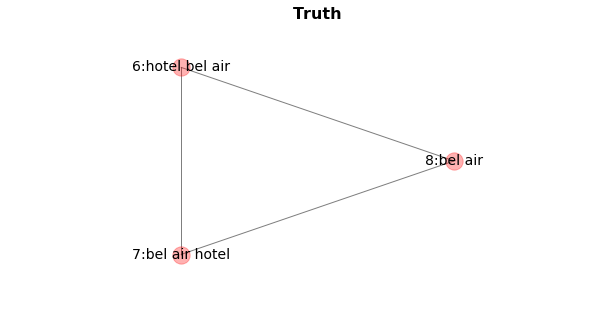

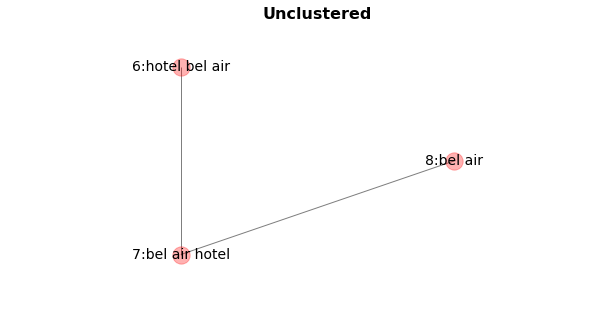

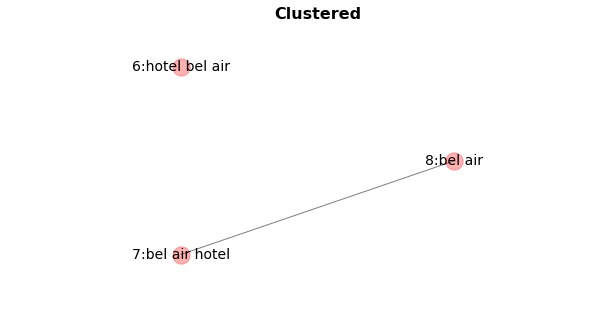

In [85]:
bad_diff_all_ids = {6, 7, 8}
show_cluster_graphs(
    df,
    golden_pairs_set, dedupe_found_pairs_set, dedupe_unclustered_found_pairs_set,
    bad_diff_all_ids)

Remember the `recall_weight` parameter of the `deduper.threshold` method? That's what it controls: how aggressive we want to be on finding or dropping matches while clustering. Check Dedupe docs for more details on how it [performs clustering](https://docs.dedupe.io/en/latest/Grouping-duplicates.html) and how it computes [a good threshold](https://docs.dedupe.io/en/latest/Choosing-a-good-threshold.html#).

Finally, it's worth mentioning there's a web-based [product version of Dedupe](https://dedupe.io/). If you don't want to write code for deduping a dataset, check it.

<center><img src="https://dedupe.io/images/tutorials/getting-started-with-dedupe-io/img-5.jpg" width=800></center>

## Next Steps

Once we have the clusters, how to consolidate data from many records into one? Check for material on **Data Fusion**:
  - [Open issue at Python Record Linkage Toolkit](https://github.com/J535D165/recordlinkage/issues/27)
  - Christen, 6.12 Merging Matches [2]

What if new records arrive? Should we merge, unmerge, move records from clusters? Check for material on **Incremental Record Linkage**:
  - Dedupe approach is to either add to an existing cluster or create a new cluster. You can use a [Gazetteer](https://docs.dedupe.io/en/latest/API-documentation.html#gazetteer-objects) with previously deduped data, then merge new matches into it, and index new nonmatches.
  - Other approaches, check papers:
      * [Online Correlation Clustering](https://arxiv.org/pdf/1001.0920.pdf)
      * [Incremental Record Linkage](http://www.vldb.org/pvldb/vol7/p697-gruenheid.pdf)
      * [Heuristic-based approaches for speeding up incremental record linkage](https://www.sciencedirect.com/science/article/pii/S0164121217302972)

Also worth checking the **Privacy** implications of Record Linkage:
- Christen, chapter 8 [2]
- [k-anonymity](https://desfontain.es/privacy/k-anonymity.html), [k-map](https://desfontain.es/privacy/k-map.html), [δ-presence](https://desfontain.es/privacy/delta-presence.html)
- [Why differential privacy is awesome](https://desfontain.es/privacy/differential-privacy-awesomeness.html)

## References

- **Referenced by this talk**:
    * [1] [Mike Mull, The Art and Science of Data Matching](https://www.youtube.com/watch?v=Y-nYEOgq3YE) (slides [here](https://github.com/mikemull/Notebooks/blob/master/PyDataNYCSlides.ipynb))
    * [2] [Peter Christen, Data Matching](http://www.springer.com/us/book/9783642311635)
    * [3] [Mikhail Yuryevich Bilenko, Learnable Similarity Functions and Their Application to Record Linkage and Clustering](http://www.cs.utexas.edu/~ml/papers/marlin-dissertation-06.pdf)
- Other **talks** about Record Linkage with Python:
    * [Andrew Rowe, Big Data Deduplication and data matching using Python](https://www.youtube.com/watch?v=Z6mlvrYEYnk)
    * [Rhydwyn Mcguire, Record linkage: Join for real life](https://www.youtube.com/watch?v=cEcVIjyHfiQ)
- [Basics of Entity Resolution with Python and Dedupe](https://medium.com/district-data-labs/basics-of-entity-resolution-with-python-and-dedupe-bc87440b64d4)
- [Automating your Data Cleanup with Python](https://blog.kjamistan.com/automating-your-data-cleanup-with-python/)
- [Comparison of Data Matching software](https://github.com/J535D165/data-matching-software)
- [Compilation of Record Linkage resources](https://github.com/ropeladder/record-linkage-resources)

# Thank you!
flavio@vinta.com.br  
[@flaviojuvenal](https://twitter.com/flaviojuvenal)  
[vinta.com.br](https://www.vinta.com.br?dedupe-slides=1)

Special thanks to Russell Keith-Magee [@freakboy3742](https://twitter.com/freakboy3742), Forest Timothy Gregg [@forestgregg](https://twitter.com/forestgregg), and Jonathan de Bruin [@J535D165](https://github.com/J535D165).